# American Monte Carlo
This notebook illustrates Longstaff-Schwartz (AMC) algorithm for pricing options and other derivatives with early-exercise features.

This jupyter notebook is based on paper **[1]**. <br>The github project also contains unit tests which are based on original numerical examples presented by Longstaff-Schwartz

**Copyright &copy; 2018 Ondrej Martinsky, All rights reserved**

[www.github.com/omartinsky/AmericanMonteCarlo](https://github.com/omartinsky/AmericanMonteCarlo)

In [1]:
%pylab
%matplotlib inline
%run jupyter_helpers
%run amc

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Definition of stochastic process

We will use a simple log-normal random walk defined as:
$$ dS_t = \mu S_t dt + \sigma S_t dX_t $$

In [2]:
class LogNormalPathGenerator(PathGeneratorBase):
    def __init__(self, timeline, path_count, s0, drift, sigma):
        super().__init__(path_count, timeline)
        s = numpy.ones(path_count) * s0
        self.slices.append(numpy.copy(s))
        for dt in numpy.diff(timeline.ndarray):
            dx = numpy.random.normal(0, 1, path_count) * dt ** .5
            ds = drift * s * dt + sigma * s * dx
            s += ds
            self.slices.append(numpy.copy(s))
            
random.seed(0)
n = 10000     # Number of simulation paths            
s0 = 1000     # Starting share price
rf = 0.02     # Drift, and also risk-free rate
sigma = 0.1   # Volatility
timeline       = TimeLine(numpy.linspace(0, 10, 100 + 1))    
path_generator = LogNormalPathGenerator(timeline, n, s0, rf, sigma)

plot:

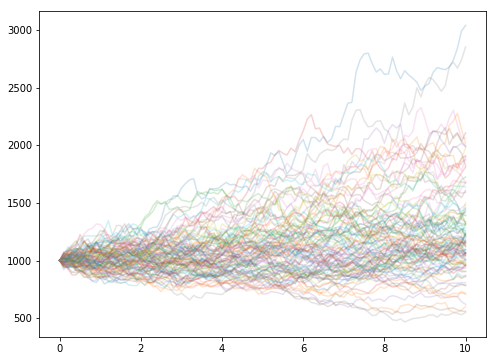

In [3]:
figsize(8, 6)
plotting.plot_paths(path_generator, 100)

# Pricing american put definition
Define a simple american put option payoff:
$$V=max(K-S, 0)$$

In general, class **PayoffBase** represents a vectorised payoff function of a single instrument or portolio of instruments

In [4]:
class PutOptionPayoff(PayoffBase):
    strike = 1000
    def get(self, observable, time):
        return numpy.maximum(self.strike - observable, 0)
payoff = PutOptionPayoff()

plot:

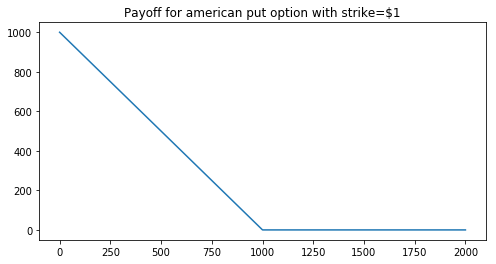

In [5]:
x = linspace(0, payoff.strike*2, 1000)
figsize(8, 4)
plot(x, payoff.get(x, 0)), title('Payoff for american put option with strike=$1');

### Run AMC
Run AMC simulation. This will use LSQ regression to decide optimal exercise points and to populate cash-flow matrix backwards.

In [6]:
amc = AmcSimulator(payoff, path_generator, timeline, rf, ConsoleLogger(LogLevel.WARNING))
amc.run()

### Plot quantiles and cash-flows
Plot quantiles of monte carlo distribution and cash-flows

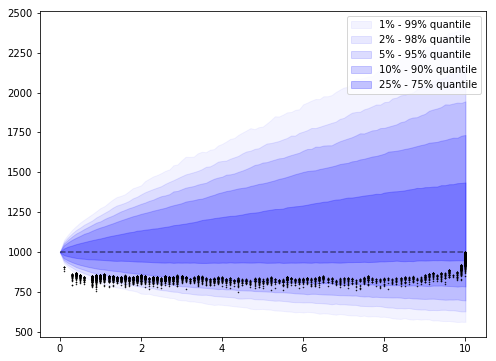

In [7]:
figsize(8, 6)
plotting.plot_quantiles(path_generator, generate_symmetric_quantiles([0.01, 0.025, 0.05, 0.1, 0.25]))
plotting.plot_cashflows(amc.cash_flow_matrix, path_generator, s=1, marker='.', color='black')
pyplot.plot(path_generator.timeline.ndarray, ones(path_generator.timeline.length) * payoff.strike, 
            color='black', linestyle='dashed', alpha=0.5); # Plot strike line

### Calculate NPV
Calculate NPV by discounting expected cash-flows from the cash-flow matrix:
$$ V_0 =\mathbb{E} \left[ \sum^T_0 Z_t C_t \right] $$
, where $C$ is the cash-flow and $Z$ is discount factor.

In [8]:
print("NPV : %0.4f" % amc.cash_flow_matrix.calc_npv(rf))

NPV : 64.8974

## References
**[1]** Valuing American Options by Simulation:
A Simple Least-Squares Approach, Francis A. Longstaff, Eduardo S. Schwartz 